In [1]:
# Ours
from work_variables import *

# Modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

from community import community_louvain as louvain
from netwulf import visualize

import requests
import re

import spacy
nlp = spacy.load("en_core_web_sm") # python -m spacy download en

# ---
# Get the book text data

book_request = requests.get(book_link)

assert book_request.status_code == 200, f"Request of the book failed. Status: {book_request.status_code}"


book_chapters = re.split(r'Chapter [0-9]+', book_request.text, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("End of Project Gutenberg")[0]


book_chapters_paragraphs = dict()
real_persons_by_paragraphs = list()


graph = nx.Graph()

In [2]:
# ---
# Cleaning and tokenization

for i, chapter in enumerate(book_chapters):

    chapter_paragraphs = list()

    # Split and clean up each paragraphs
    paragraphs = chapter.split('\r\n\r\n')
    for paragraph in paragraphs:
        clean_paragraph = re.sub(r"[\"\?\!\-\.\,\;\:\(\)\s]+", ' ', paragraph)
        chapter_paragraphs.append(clean_paragraph)

        # Tag and detect every person's name by paragraph
        tokens = nlp(clean_paragraph)
        paragraph_persons = [ent.text for ent in tokens.ents if ent.label_ == "PERSON"]

        # Correct all possible mentions of a person
        # And remove false positive

        real_paragraph_persons = []
        for person in paragraph_persons:
            if person in persons_real_names: real_paragraph_persons.append(person)
            else: 
                for check, replace in name_to_replace.items():
                    reg = re.compile(check, )
                    if reg.match(person): 
                        real_paragraph_persons.append(replace)
                        break

        # DEBUG
        # print(set(paragraph_persons), set(real_paragraph_persons))
        # time.sleep(0.2)
        
        real_persons_by_paragraphs.append(set(real_paragraph_persons))

    book_chapters_paragraphs[i] = chapter_paragraphs

In [3]:
# ---
# Graph Filling
# Add edge between 2 characters of the same paragraph

for unique_paragraph_persons in real_persons_by_paragraphs: 
    if len(unique_paragraph_persons) < 2 : continue
    graph.add_nodes_from(unique_paragraph_persons)
    unique = list(unique_paragraph_persons)
    for idx in range(len(unique)-1):
        edge = graph.get_edge_data(unique[idx], unique[idx-1])
        if edge is not None : graph[unique[idx]][unique[idx-1]]['weight'] += 1
        else : graph.add_edge(unique[idx], unique[idx-1], weight=1)

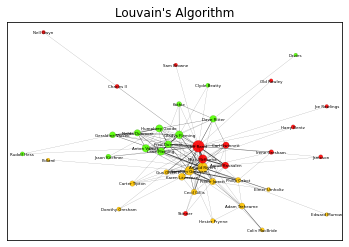

In [89]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

partition = louvain.best_partition(graph)

ass = nx.degree_assortativity_coefficient(graph)

# TODO: Store and compare multiple times the partition to check if it's equals. 
# If yes, then we could conclude that the partition of communities is relevant.

pos = nx.spring_layout(graph)
cmap = cm.get_cmap('prism', max(partition.values()) + 1)

node_sizes = [len(list(graph.neighbors(person)))*4+10 for person in graph.nodes]
edge_weights = list(min(v/8, 1) for v in nx.get_edge_attributes(graph,'weight').values())

nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=node_sizes, edgecolors = "black", linewidths=0.1, alpha = 0.9, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.8, width = edge_weights)
nx.draw_networkx_labels(graph,  pos, {n: n for n in partition}, font_size=4, alpha = 1) 

plt.title("Louvain's Algorithm")
plt.show()

In [68]:
# ---
# K-Core decomposition
# Reworked version

def kcore(graph):

    knots, decomposition = {}, {}

    # Using the class Point() in work_variables.py
    # knots = [Point(person, list(graph.neighbors(person))) for person in graph.nodes]

    # Using a dictionary
    for person in graph.nodes:
        neighbors = list(graph.neighbors(person))
        knots[person] = {"neighbors": neighbors, "degree": len(neighbors), "pruned": False}

    k, total_pruned = 1, 0

    while total_pruned < len(graph):
        to_prune = [person for person,elems in knots.items() if elems['degree'] == k]
        k_shell = []
        while len(to_prune) > 0:
            x = to_prune.pop(0)
            for n in knots.get(x)['neighbors']:
                v = knots.get(n)
                if not v['pruned']:
                    v['degree'] -= 1
                    if v['degree'] == k : to_prune.append(n)
            knots.get(x)['pruned'] = True
            k_shell.append(x)
            total_pruned += 1
        decomposition[k] = sorted(k_shell)
        k += 1
    
    return decomposition 

kcore_output = kcore(graph)
                